In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## How many different cases are there, by department?

In [24]:
(
df.groupBy('department')
    .count()
    .show()
)
# those are all the cases by dept, trying to get distinct cases

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [25]:
df.createOrReplaceTempView('df')

In [30]:
spark.sql('''
SELECT department, COUNT(DISTINCT(df.service_request_type)) as Different_case_types
FROM df
GROUP BY department
''').show()

+--------------------+--------------------+
|          department|Different_case_types|
+--------------------+--------------------+
|         Solid Waste|                  56|
|Animal Care Services|                  14|
|Trans & Cap Impro...|                  81|
|  Parks & Recreation|                  44|
|    Customer Service|                   2|
|        Metro Health|                  14|
|        City Council|                   2|
|DSD/Code Enforcement|                 122|
+--------------------+--------------------+



## Does the percentage of cases that are late vary by department?

In [48]:
(
df.withColumn("case_closed",df.case_closed.cast('int'))
    # note how we check the ouput of just this code to make sure before proceeding
.groupBy('department')
    .agg(mean('case_closed'))
#     .orderBy("true")
.show(vertical=True)
)

-RECORD 0--------------------------------
 department       | Solid Waste          
 avg(case_closed) | 0.9942349697425431   
-RECORD 1--------------------------------
 department       | Animal Care Services 
 avg(case_closed) | 0.9959885386819485   
-RECORD 2--------------------------------
 department       | Trans & Cap Impro... 
 avg(case_closed) | 0.9768070441716133   
-RECORD 3--------------------------------
 department       | Parks & Recreation   
 avg(case_closed) | 0.980107499874416    
-RECORD 4--------------------------------
 department       | Customer Service     
 avg(case_closed) | 0.5910845910845911   
-RECORD 5--------------------------------
 department       | Metro Health         
 avg(case_closed) | 0.9854735618826264   
-RECORD 6--------------------------------
 department       | City Council         
 avg(case_closed) | 0.12121212121212122  
-RECORD 7--------------------------------
 department       | DSD/Code Enforcement 
 avg(case_closed) | 0.962240255901

In [58]:
answer2 = (
df.withColumn("case_closed",df.case_closed.cast('int'))
    # note how we check the ouput of just this code to make sure before proceeding
.groupBy('department')
    .agg(mean('case_closed').alias('percent_case_closed'))
#     .orderBy("true")
.toPandas()
)

In [59]:
answer2.set_index('department')

,percent_case_closed
department,
Solid Waste,0.994235
Animal Care Services,0.995989
Trans & Cap Improvements,0.976807
Parks & Recreation,0.980107
Customer Service,0.591085
Metro Health,0.985474
City Council,0.121212
DSD/Code Enforcement,0.962240


Text(0.5, 1.0, 'Percent Case Closed By Department')

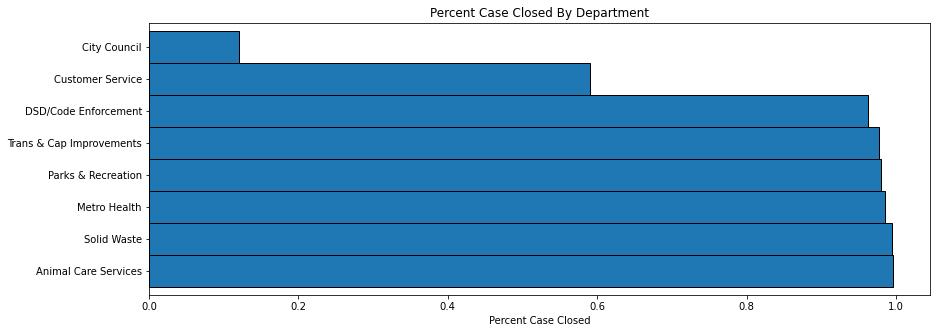

In [61]:
(
answer2.set_index("department")
    .percent_case_closed.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Percent Case Closed")
plt.ylabel("")
plt.title("Percent Case Closed By Department")


## On average, how late are the late cases by department?

In [66]:
# (
# df.where("case_late")
#     # note how we check the ouput of just this code to make sure before proceeding
# .groupBy('department')
#     .agg(mean('num_days_late'))
# #     .orderBy("true")
# .show(vertical=True)
# )

answer3 = (
df.where("case_late")
    # note how we check the ouput of just this code to make sure before proceeding
.groupBy('department')
    .agg(mean('num_days_late').alias('mean_days_late'))
    .toPandas()
# .show(vertical=True)
)

In [67]:
answer3

,department,mean_days_late
0,Solid Waste,7.186822
1,Animal Care Services,23.458633
2,Trans & Cap Improvements,10.603065
3,Parks & Recreation,22.348910
4,Customer Service,87.683859
5,Metro Health,6.543813
6,DSD/Code Enforcement,49.384287


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Solid Waste'),
  Text(1, 0, 'Animal Care Services'),
  Text(2, 0, 'Trans & Cap Improvements'),
  Text(3, 0, 'Parks & Recreation'),
  Text(4, 0, 'Customer Service'),
  Text(5, 0, 'Metro Health'),
  Text(6, 0, 'DSD/Code Enforcement')])

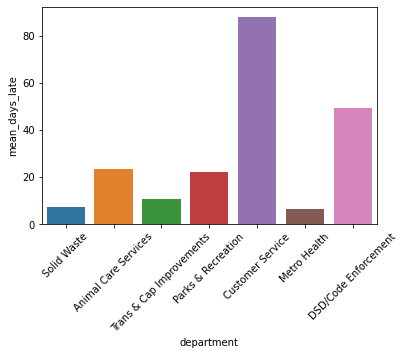

In [70]:
sns.barplot(data=answer3, x='department', y='mean_days_late')
plt.xticks(rotation=45)

## What is the service type that is the most late? Just for Parks & Rec?

In [103]:
(
df.groupBy('service_request_type')
    .agg(mean(df.num_days_late).alias('avg_days_late'))
#     .where('avg_days_late' > 0)
    .sort(col('avg_days_late').desc()).limit(10)#.desc('avg_days_late')
    .show()
)



+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|  Zoning: Junk Yards|175.95636210420943|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Storage of Used M...|142.11255641500003|
|Zoning: Recycle Yard|135.92851612479797|
|Donation Containe...|131.75610506358706|
|License Requied U...|128.79828704142858|
|Traffic Signal Gr...| 77.90021217000002|
|           Complaint|  72.5179093265971|
+--------------------+------------------+



In [106]:
df.select('department').distinct().show()

+--------------------+
|          department|
+--------------------+
|         Solid Waste|
|Animal Care Services|
|Trans & Cap Impro...|
|  Parks & Recreation|
|    Customer Service|
|        Metro Health|
|        City Council|
|DSD/Code Enforcement|
+--------------------+



In [107]:
(
df.filter(df['department']=='Parks & Recreation')
    .groupBy('service_request_type')
    .agg(mean(df.num_days_late).alias('avg_days_late'))
#     .where('avg_days_late' > 0)
    .sort(col('avg_days_late').desc()).limit(10)#.desc('avg_days_late')
    .show()
)




+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Reservation Assis...|       66.03116319|
|Park Building Mai...|24.322320840895838|
| Sportfield Lighting|  19.3770910626007|
|          Electrical|11.750504897402122|
|Amenity Park Impr...|10.114974371919642|
|        Tree Removal|5.6582362742885906|
|            Painting| 4.354412358281139|
|Tree Trimming/Mai...| 4.241499056964816|
|General Building ...| 4.191945529579545|
|             Masonry|4.1756982508859055|
+--------------------+------------------+



## For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
## Does whether or not its a weekend matter for when a case is opened/closed?
## On average, how many cases are opened a day for the Customer Service department?
## Does the number of service requests for the solid waste department vary by day of the week?